It is highly recommended to use a powerful **GPU**, you can use it for free uploading this notebook to [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb).
<table align="center">
 <td align="center"><a target="_blank" href="https://colab.research.google.com/github/ezponda/intro_deep_learning_solutions/blob/main/class/Fundamentals/NN_Fundamentals.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/ezponda/intro_deep_learning_solutions/blob/main/class/Fundamentals/NN_Fundamentals.ipynb">
        <img src="https://i.ibb.co/xfJbPmL/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[:,0], X[:,1], c=y.ravel(), cmap=plt.cm.Spectral)

def load_planar_dataset(m, sigma=0.2):
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*sigma # theta
        r = a*np.sin(4*t) + np.random.randn(N)*sigma # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    ## premuting ouput
    p = np.random.permutation(m)
    X = X[p,:]
    Y = Y[p,:]

    return X, Y.ravel()

def draw_neural_net(left, right, bottom, top, layer_sizes):
    '''
    From https://gist.github.com/craffel/2d727968c3aaebd10359#file-draw_neural_net-py
    Draw a neural network cartoon using matplotilb.

    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])

    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    fig = plt.figure(figsize=(3, 3))
    ax = fig.gca()
    ax.axis('off')

    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

## Dataset

We have a binary classification dataset. The target `y` has two possible values, {0,1} and the input vector `x` has two dimensions.

In [4]:
N = 5000
X, y = load_planar_dataset(N, 0.2)

生成 5000 个样本 的玩具数据集。

load_planar_dataset(N, 0.2)：常见的教学函数，产生花朵/花瓣形状的非线性可分数据；0.2 多半是噪声/随机扰动强度。

Visualize the dataset using matplotlib. The data looks like a "flower" with some red (label y=0) and some blue (y=1) points. Your goal is to build a model to fit this data.

Visualize the dataset using matplotlib. The data looks like a "flower" with some red (label y=0) and some blue (y=1) points. Your goal is to build a model to fit this data.

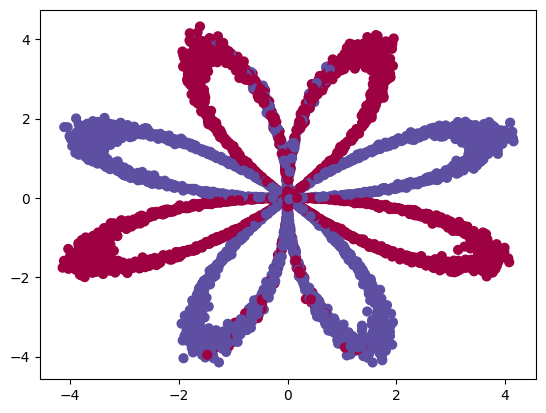

In [5]:
# Visualize the data:
plt.scatter(X[:,0], X[:,1], c=y.ravel(), s=40, cmap=plt.cm.Spectral);

In [6]:
# train test split
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(
    X,
    y,
    test_size=0.2,
)

In [7]:
print('X shape:{0}, y shape:{1}'.format(X.shape, y.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train.shape,
                                                    y_train.shape))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test.shape, y_test.shape))

X shape:(5000, 2), y shape:(5000,)
X_train shape:(4000, 2), y_train shape:(4000,)
X_test shape:(1000, 2), y_test shape:(1000,)


In [8]:
## X first example
X[0,:]

array([-0.18886021,  0.19722999])

In [9]:
## Y firsts examples
y[:8]

array([0, 1, 1, 0, 0, 0, 1, 1], dtype=uint8)

## First NN in Keras

### Logistic regression

Fully connected layers are defined using the [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) class. We can specify the number of neurons as the first argument, and specify the activation function using the activation argument.

```python
tf.keras.layers.Dense(
    units, activation=None
)

```

- **units**: Number of neurons in the layer.
- **activation**: Activation function to use, default function is `linear`, you can also use `sigmoid` for sigmoid activation or [other alternatives](https://www.tensorflow.org/api_docs/python/tf/keras/activations)

For defining the input layer you can use `keras.Input(shape=(input_dimension,))` or define your input dimension in the first hidden layer.

```python
layers.Dense(4, activation="sigmoid", input_shape=(input_dimension,))

```

Build a network without hidden layer

Dense 是什么？

Dense（全连接层）＝每个输入特征都会和该层里的每个神经元相连。

计算公式：y = activation(Wx + b) —— 先线性组合 Wx+b，再过激活函数。

Dense(1, sigmoid)：把“分数”变成“概率”，像把考试原分折算成 0~1 的及格概率。

阈值 0.5：像定条“及格线”；上面判 1，下面判 0。

sigmoid：输出 0~1，常用在二分类的输出层。

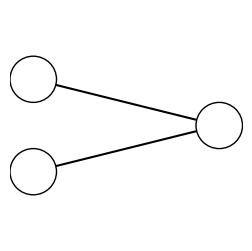

In [10]:
draw_neural_net(.1, .9, .1, .9, [2, 1])


左边两个空心圈＝2 个输入特征（x1, x2）。

右边一个空心圈＝1 个输出神经元（给出“是/否”的概率）。

中间没有隐藏层，只有输入直接连到输出。 ⇒ 这就是“线性模型 + sigmoid”，等价于逻辑回归。

In [11]:
model = keras.Sequential()
# The dimension of the input is 2 (planar data)
# we have only one output layer with 1 neuron
model.add(keras.layers.Dense(1, input_shape=(2, ), activation='sigmoid'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Dense(1, ...) → 这一层有 1 个神经元，输出形状是 (batch_size, 1)。

input_shape=(2,) → 告诉第一层：每个样本有 2 个特征。

activation='sigmoid' → 把线性结果压到 0~1，用于二分类概率。

批量维度是动态的：输入形状 (None, 2) → 输出形状 (None, 1)。

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3 (12.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)

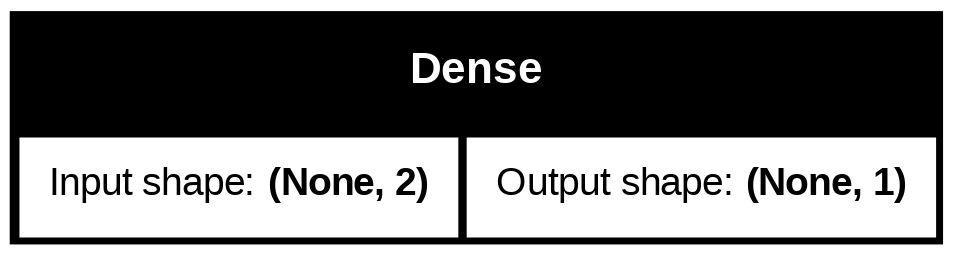

In [13]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

#### Compile
Now we need to specify the loss function, the metrics and the optimizer. It is done using compile function in Keras.

In [14]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

解释 Keras 的 model.compile(...)：告诉模型用什么优化器、什么损失函数、评什么指标。逐项看👇

三个关键参数

optimizer='adam' 训练时怎么更新权重。adam 很通用、收敛快；需要的话可调速率：adam(learning_rate=1e-3)。

loss='binary_crossentropy' 训练目标：最小化二分类的对数损失。适用于输出层是 Dense(1, activation='sigmoid')的二分类。 常见对应关系：

二分类：Dense(1, sigmoid) → loss='binary_crossentropy'

多分类（标签是 0/1/2… 的整数）：Dense(K, softmax) → loss='sparse_categorical_crossentropy'

多分类（one-hot 标签）：Dense(K, softmax) → loss='categorical_crossentropy'

回归：Dense(1, linear) → loss='mse' 或 mae

metrics=['accuracy'] 只用于显示（不参与优化），训练/验证时打印准确率。



Training model
This is similar to a sklearn model.

Train（训练集）：用来拟合参数（让模型学）。

Validation（验证集）：在训练过程中调超参/选模型（比如层数、学习率、早停 EarlyStopping 的监控），不能参与训练，否则会“自吹自擂”。

Test（测试集）：最后一次评估，模拟真正在新数据上的表现；整个训练与调参过程中都不能碰，避免数据泄漏。

你的流程是：

先用 train_test_split(..., test_size=0.2) 把原始数据切为 Train(80%) + Test(20%)；

然后在 model.fit(..., validation_split=0.2) 里，再把训练集里的 20%拿出来当 Validation（也就是 Train→(Train_inner 80% + Val 20%)）。

这就是为什么“训练集再分一次”。

#### Training model
This is similar to a sklearn model.

In [15]:
model.fit(X_train, y_train, epochs=10,
          validation_split=0.2, batch_size=32)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3047 - loss: 1.4521 - val_accuracy: 0.3113 - val_loss: 1.3242
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3015 - loss: 1.3403 - val_accuracy: 0.3100 - val_loss: 1.2238
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3110 - loss: 1.2253 - val_accuracy: 0.3113 - val_loss: 1.1297
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3231 - loss: 1.1337 - val_accuracy: 0.3125 - val_loss: 1.0425
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3206 - loss: 1.0503 - val_accuracy: 0.3150 - val_loss: 0.9638
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3224 - loss: 0.9640 - val_accuracy: 0.3187 - val_loss: 0.8955
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3252 - loss: 0.9038 - val_accuracy: 0.3225 - val_loss: 0.8386
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3308 - loss: 0.8333 - val_accuracy: 0.


Epoch 1/10 ... accuracy: 0.5647 - loss: 0.6956 - val_accuracy: 0.6687 - val_loss: 0.6811

训练集准确率 ~0.56，验证集准确率 ~0.67（validation_split=0.2 从训练集中再切 20% 当验证集）。

到第 10 轮：accuracy ~0.48，val_accuracy ~0.44，val_loss ~0.6646。

这代表什么？

线性模型学不到好边界：你现在是逻辑回归（Dense(1, sigmoid) 无隐藏层），决策边界是一条直线。很多“月牙 / 圆环 / Xor”类数据线性不可分，所以准确率徘徊在 0.45～0.67。

波动较大：说明模型对验证子集不稳，或类别比例不均衡、或学习率/批量设置与数据噪声使得训练不稳定。

loss ≈ 0.66 接近“随便猜（0.5 概率）”的交叉熵水平，进一步印证“模型过于简单”。

#### Making predictions

In [16]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.7407829761505127
Test Accuracy: 0.3790000081062317


In [17]:
y_pred = model.predict(X_test)
y_pred[:3], y_test[:3]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


(array([[0.4868688],
        [0.5336468],
        [0.5018176]], dtype=float32),
 array([0, 0, 0], dtype=uint8))

32576/32576 ━━━━━━━━━━━━━━━━━━━━ 33s 1ms/step


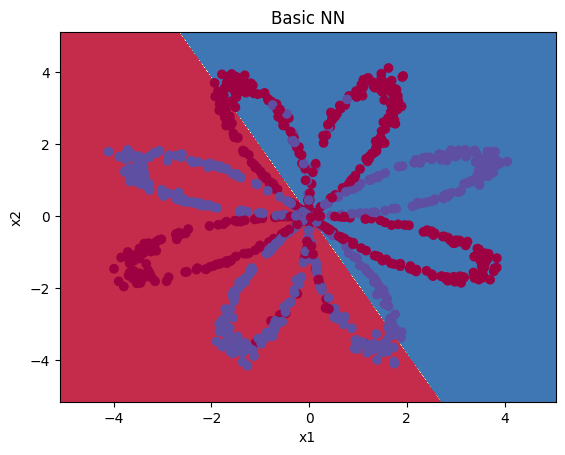

In [18]:
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("Basic NN");

### One hidden layer NN

- One **input with 2 features (input_shape)**
- **One hidden dense layer**,  with **3 neurons** and implemented with  **sigmoid activating function**
- **One Output** (sigmoid output activation function)

We can create layers incrementally with the method `add()`:

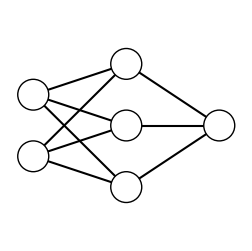

In [19]:
draw_neural_net(.1, .9, .1, .9, [2, 3, 1])

In [20]:
model = keras.Sequential()

## hidden layer with 3 neurons and sigmoid activation
## The first layer need to have the input_shape
model.add(layers.Dense(3, input_shape=(2,), activation='sigmoid'))

# output layer
model.add(layers.Dense(1, activation='sigmoid'))

## model summary
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 3)              │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13 (52.00 B)

 Trainable params: 13 (52.00 B)

 Non-trainable params: 0 (0.00 B)

dense_3 (Dense) → Output Shape: (None, 3)
隐藏层有 3 个神经元，所以输出是长度 3 的向量。

dense_4 (Dense) → Output Shape: (None, 1)
输出层有 1 个神经元，用 sigmoid 产生属于正类(1)的概率。

为什么总参数是 13？

Dense 层参数 = 权重(输入数 × 输出数) + 偏置(输出数)

第一层：输入 2 → 输出 3 ⇒ 2×3 + 3 = 9

第二层：输入 3 → 输出 1 ⇒ 3×1 + 1 = 4

总计：9 + 4 = 13（与表格一致）

You can also define the model with a list of layers
```python
model = keras.Sequential([
    keras.Input(shape=(2, )),
    layers.Dense(3, activation='sigmoid', name='layer1'),
    layers.Dense(1, activation='sigmoid', name='layer3')
])
````

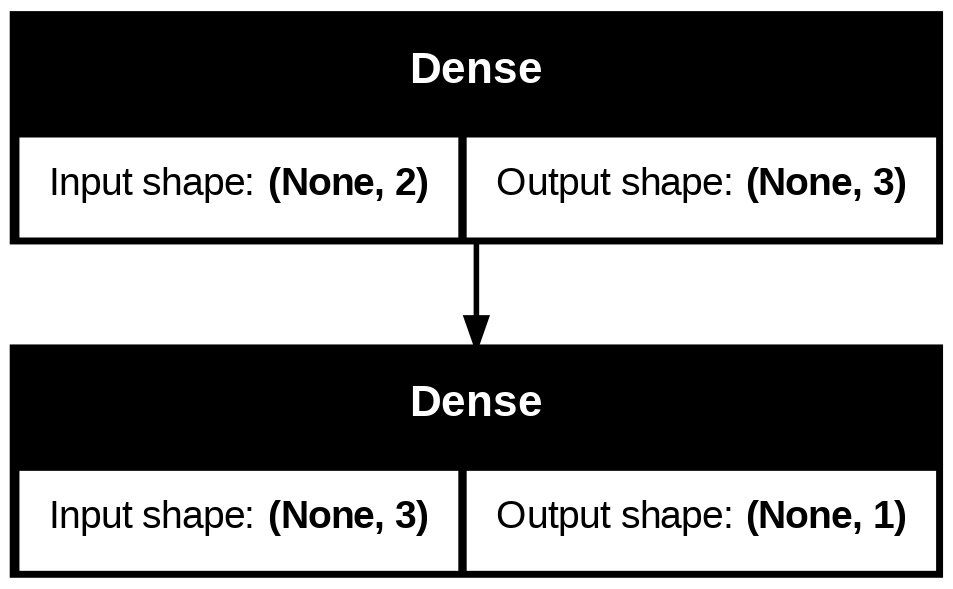

In [21]:
plot_model(model, show_shapes=True)

In [22]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5143 - loss: 0.6900 - val_accuracy: 0.4863 - val_loss: 0.6871
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5243 - loss: 0.6840 - val_accuracy: 0.6037 - val_loss: 0.6801
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6200 - loss: 0.6761 - val_accuracy: 0.6263 - val_loss: 0.6742
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6360 - loss: 0.6705 - val_accuracy: 0.6350 - val_loss: 0.6686
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6368 - loss: 0.6640 - val_accuracy: 0.6237 - val_loss: 0.6633
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6371 - loss: 0.6568 - val_accuracy: 0.6187 - val_loss: 0.6583
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6048 - loss: 0.6566 - val_accuracy: 0.6175 - val_loss: 0.6538
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6089 - loss: 0.6503 - val_accuracy: 0.

In [23]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.5835614800453186
Test Accuracy: 0.6209999918937683


32576/32576 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step


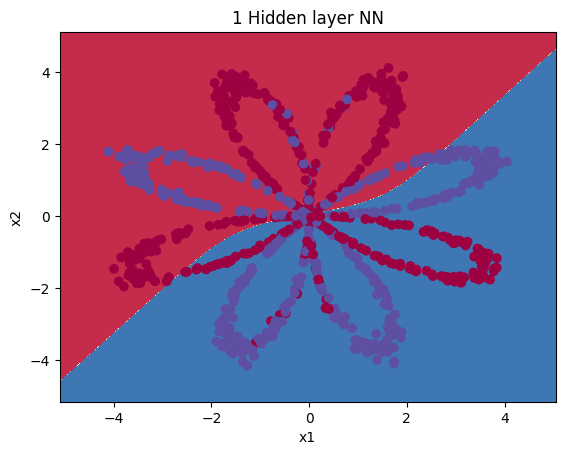

In [24]:
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN");

### Question 1:
####  What happens if we change the activation function of the first hidden  layer to `'linear'`?

In [25]:
model = keras.Sequential()
## The first layer need to have the input_shape
## change the activation function
model.add(layers.Dense(3, input_shape=(2,), activation='linear'))
# output layer
model.add(layers.Dense(1, activation='sigmoid'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4694 - loss: 1.3696 - val_accuracy: 0.4963 - val_loss: 1.2051
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4715 - loss: 1.1845 - val_accuracy: 0.5088 - val_loss: 1.0270
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5013 - loss: 0.9572 - val_accuracy: 0.5400 - val_loss: 0.8822
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5443 - loss: 0.8314 - val_accuracy: 0.6162 - val_loss: 0.7677
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6469 - loss: 0.7294 - val_accuracy: 0.6762 - val_loss: 0.7040
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6599 - loss: 0.6693 - val_accuracy: 0.5612 - val_loss: 0.6794
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5389 - loss: 0.6706 - val_accuracy: 0.4837 - val_loss: 0.6726
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4747 - loss: 0.6676 - val_accuracy: 0.

Test Loss: 0.6511735916137695
Test Accuracy: 0.4749999940395355
32576/32576 ━━━━━━━━━━━━━━━━━━━━ 35s 1ms/step


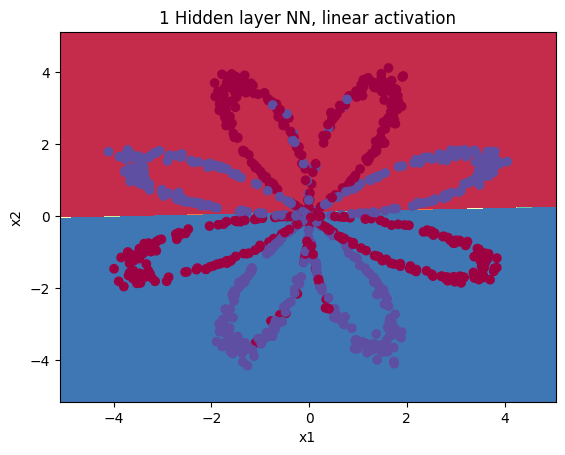

In [27]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN, linear activation");

### Question 2:
####  What happens if we add more neurons to the first hidden layer ?

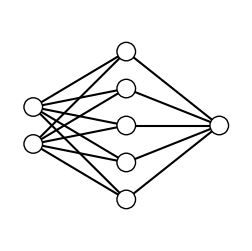

In [33]:
draw_neural_net(.1, .9, .1, .9, [2, 5, 1])

In [34]:
model = keras.Sequential()

## The first layer need to have the input_shape
## set the number of neurons
model.add(layers.Dense(5, input_shape=(2,), activation='sigmoid'))

# output layer
model.add(layers.Dense(1, activation='sigmoid'))

In [35]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3783 - loss: 0.7957 - val_accuracy: 0.3613 - val_loss: 0.7629
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3447 - loss: 0.7643 - val_accuracy: 0.3400 - val_loss: 0.7390
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3374 - loss: 0.7395 - val_accuracy: 0.3262 - val_loss: 0.7212
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3463 - loss: 0.7196 - val_accuracy: 0.3425 - val_loss: 0.7055
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3727 - loss: 0.7035 - val_accuracy: 0.4575 - val_loss: 0.6924
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5826 - loss: 0.6890 - val_accuracy: 0.7000 - val_loss: 0.6814
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6671 - loss: 0.6777 - val_accuracy: 0.6562 - val_loss: 0.6722
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6560 - loss: 0.6679 - val_accuracy:

Test Loss: 0.5810484290122986
Test Accuracy: 0.6230000257492065
32576/32576 ━━━━━━━━━━━━━━━━━━━━ 33s 1ms/step


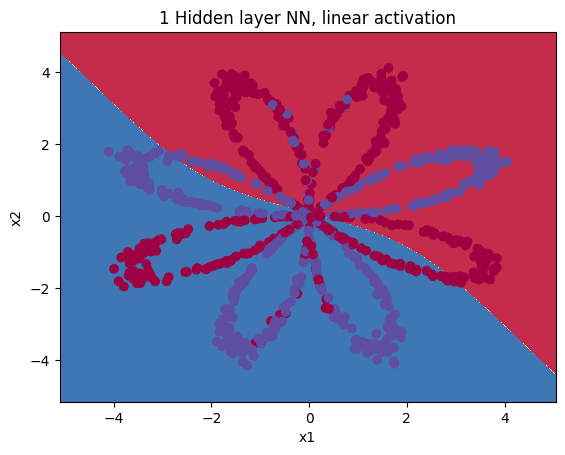

In [36]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN, linear activation");

### Question 3:
####  What happens if we add one more hidden layer ?

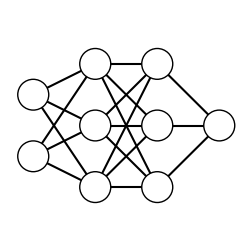

In [37]:
draw_neural_net(.1, .9, .1, .9, [2, 3, 3, 1])

In [41]:
model = keras.Sequential()
# First hidden layer (need to innclude input_shape)
## Set the number of neurons
model.add(layers.Dense(3, input_shape=(2,), activation='sigmoid'))

# second hidden layer
## Complete the code
model.add(layers.Dense(3, activation='sigmoid'))

# output layer
model.add(layers.Dense(1, activation='sigmoid'))

In [42]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5017 - loss: 0.7120 - val_accuracy: 0.5013 - val_loss: 0.6965
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4993 - loss: 0.6939 - val_accuracy: 0.5675 - val_loss: 0.6873
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5997 - loss: 0.6855 - val_accuracy: 0.7025 - val_loss: 0.6806
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7470 - loss: 0.6785 - val_accuracy: 0.7937 - val_loss: 0.6740
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7954 - loss: 0.6722 - val_accuracy: 0.7375 - val_loss: 0.6675
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7281 - loss: 0.6662 - val_accuracy: 0.7275 - val_loss: 0.6609
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7211 - loss: 0.6579 - val_accuracy: 0.7075 - val_loss: 0.6539
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7184 - loss: 0.6514 - val_accuracy: 0

Test Loss: 0.47212234139442444
Test Accuracy: 0.8510000109672546
32576/32576 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step


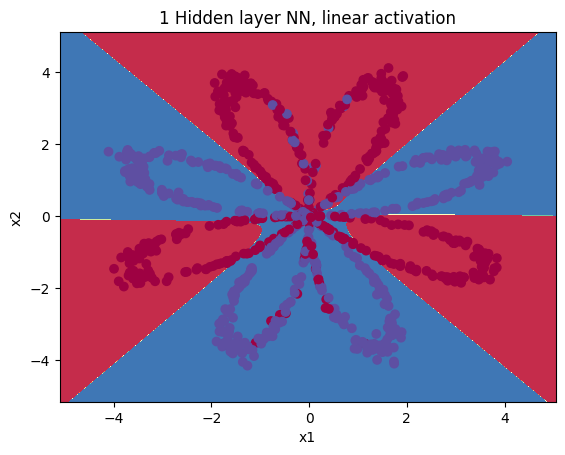

In [43]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN, linear activation");

####  Use  the [hyperbolic tangent](https://mathworld.wolfram.com/HyperbolicTangent.html) activation `'tanh'` with the first simple model and compare the results with the sigmoid activation

In [44]:
model = keras.Sequential()
## The first layer need to have the input_shape
## change the activation function
model.add(layers.Dense(3, input_shape=(2,), activation='tanh')) # or "relu"
# output layer
model.add(layers.Dense(1, activation='sigmoid'))

In [45]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4635 - loss: 0.9040 - val_accuracy: 0.4900 - val_loss: 0.8699
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5061 - loss: 0.8325 - val_accuracy: 0.5038 - val_loss: 0.7933
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5231 - loss: 0.7681 - val_accuracy: 0.5863 - val_loss: 0.7236
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6200 - loss: 0.7030 - val_accuracy: 0.6125 - val_loss: 0.6775
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6333 - loss: 0.6687 - val_accuracy: 0.6200 - val_loss: 0.6512
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6536 - loss: 0.6395 - val_accuracy: 0.6263 - val_loss: 0.6361
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6417 - loss: 0.6325 - val_accuracy: 0.6338 - val_loss: 0.6261
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6497 - loss: 0.6218 - val_accuracy: 0.

Test Loss: 0.4045027792453766
Test Accuracy: 0.8830000162124634
32576/32576 ━━━━━━━━━━━━━━━━━━━━ 33s 1ms/step


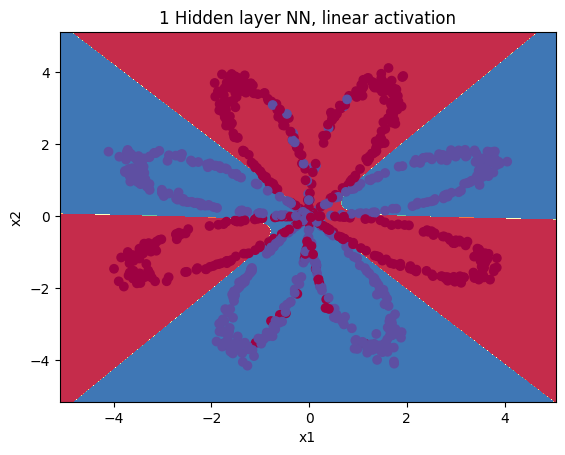

In [46]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN, linear activation");

## Practice I

Repeat the process with a different dataset.

In [47]:
N = 5000
X, y = sklearn.datasets.make_moons(n_samples=N, noise=.18)

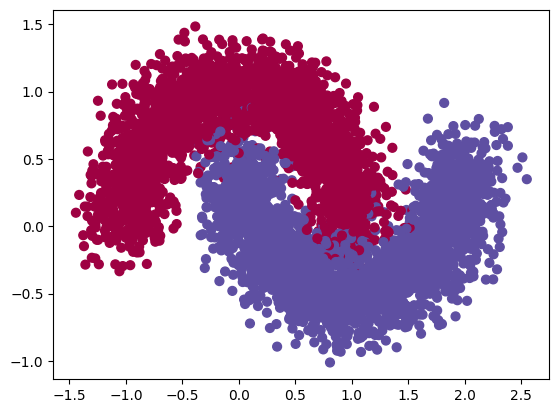

In [48]:
# Visualize the data:
plt.scatter(X[:,0], X[:,1], c=y.ravel(), s=40, cmap=plt.cm.Spectral);

In [49]:
# train test split
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(
    X,
    y,
    test_size=0.25,
)
print('X shape:{0}, y shape:{1}'.format(X.shape, y.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train.shape,
                                                    y_train.shape))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test.shape, y_test.shape))

X shape:(5000, 2), y shape:(5000,)
X_train shape:(3750, 2), y_train shape:(3750,)
X_test shape:(1250, 2), y_test shape:(1250,)


### Define your model

In [50]:
model = keras.Sequential()
## The first layer need to have the input_shape
model.add(layers.Dense(16, input_shape=(2,), activation='tanh'))

## Second Layer, don't use input_shape
model.add(layers.Dense(16, activation='tanh'))

# output layer
model.add(layers.Dense(1, activation='sigmoid'))

In [51]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=35, validation_split=0.2, batch_size=64)

Epoch 1/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8577 - loss: 0.5190 - val_accuracy: 0.8440 - val_loss: 0.4054
Epoch 2/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8378 - loss: 0.3907 - val_accuracy: 0.8613 - val_loss: 0.3390
Epoch 3/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8541 - loss: 0.3322 - val_accuracy: 0.8720 - val_loss: 0.3082
Epoch 4/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8678 - loss: 0.3032 - val_accuracy: 0.8733 - val_loss: 0.2945
Epoch 5/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8661 - loss: 0.3031 - val_accuracy: 0.8760 - val_loss: 0.2899
Epoch 6/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8694 - loss: 0.2953 - val_accuracy: 0.8787 - val_loss: 0.2877
Epoch 7/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8625 - loss: 0.3019 - val_accuracy: 0.8773 - val_loss: 0.2860
Epoch 8/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8785 - loss: 0.2780 - val_accuracy: 0.8760 - val_lo

Test Loss: 0.09867528825998306
Test Accuracy: 0.9624000191688538
7979/7979 ━━━━━━━━━━━━━━━━━━━━ 8s 960us/step


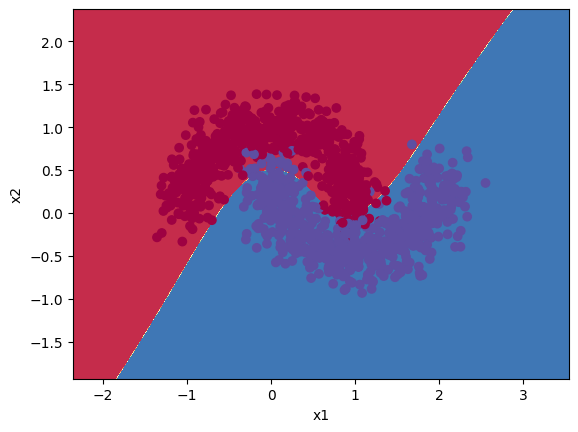

In [52]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)

## Functional API

The Keras Functional API allows defining the topology of the models as a [acyclic directed graph](https://en.wikipedia.org/wiki/Directed_acyclic_graph) of layers. Next we will build the same model as in the previous section but using the Keras Functional API.

You need to start with an input data entry:
```python    
    inputs = keras.Input(shape=(8,))
```
    
We define the layers that we will include in the network and the relationships between them. It is important to note that each line details the type of layer and its properties (number of neurons, activation function, name ...) and just at the end, in parentheses, the name of the variable in which we have saved the layer from which its output will connect to the input of the layer we are declaring.
```python
layer_1 = layers.Dense(4, activation='sigmoid',
                       name='layer_1')(inputs)
layer_2 = layers.Dense(4, activation='sigmoid',
                       name='layer_2')(layer_1)
```

The "layer call" `Dense()(inputs)` action is like drawing an arrow from "inputs" to this layer you created. You're "passing" the inputs to the dense layer, and you get `layer_1` as the output.

  

Finally, we define the network outputs:
```python
outputs = layers.Dense(1, name='output_layer')(layer_2)
```

We create the model specifying the inputs and outputs:
```python
model = keras.Model(inputs=inputs, outputs=outputs)
```

Keras 的 Functional API（函数式接口），用“把张量从一层传到下一层”的方式来搭网络。它和 Sequential 一样能搭普通串联网络，但更灵活（可多输入/多输出、分叉/合并、跳连等）。

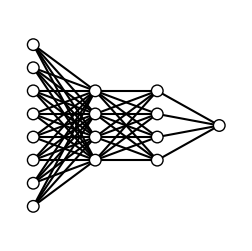

In [53]:
draw_neural_net(.1, .9, .1, .9, [8, 4, 4, 1])

In [54]:
inputs = keras.Input(shape=(8, ), name='input_layer')
l_1 = layers.Dense(4, activation='relu', name='layer_1')(inputs)
l_2 = layers.Dense(4, activation='relu', name='layer_2')(l_1)
outputs = layers.Dense(1, name='output_layer')(l_2)

model = keras.Model(inputs=inputs, outputs=outputs, name='example_model')

model.summary()

Model: "example_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61 (244.00 B)

 Trainable params: 61 (244.00 B)

 Non-trainable params: 0 (0.00 B)

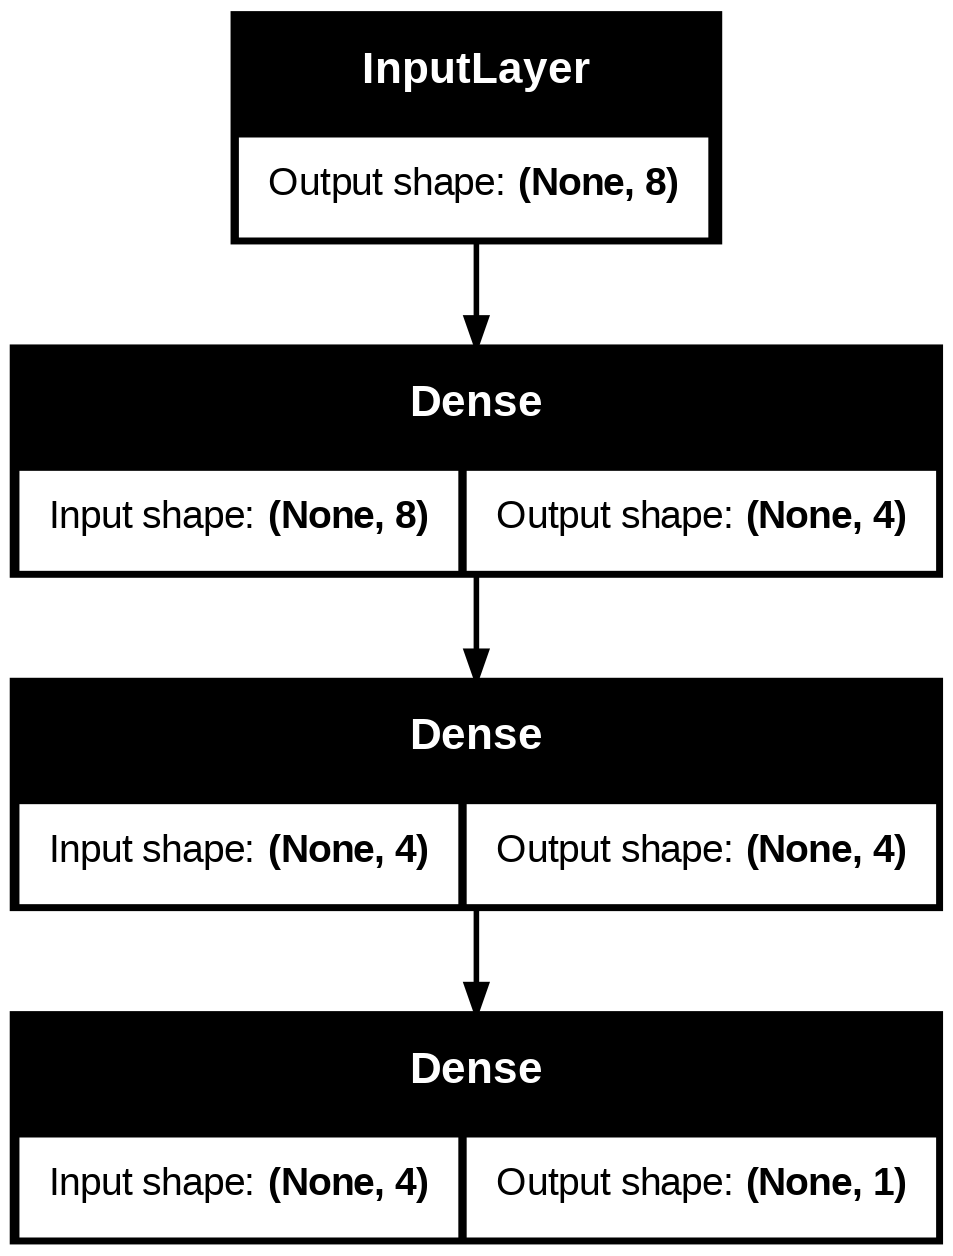

In [55]:
plot_model(model, show_shapes=True)

## Practice II

Repeat the process with a different dataset and the **Functional API**

In [56]:
N = 5000
X, y = sklearn.datasets.make_circles(n_samples=N, factor=.65, noise=.065) # sklearn.datasets.make_moons(n_samples=N, noise=.15)

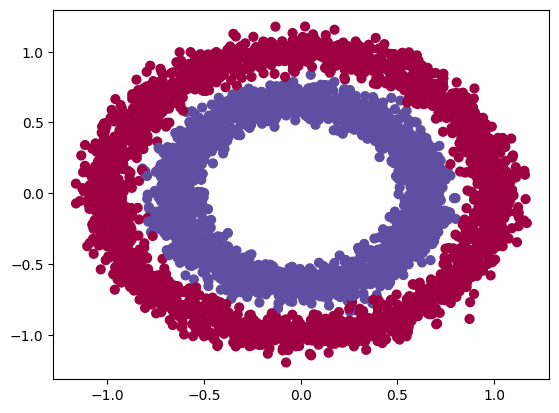

In [57]:
# Visualize the data:
plt.scatter(X[:,0], X[:,1], c=y.ravel(), s=40, cmap=plt.cm.Spectral);

In [58]:
# train test split
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(
    X,
    y,
    test_size=0.25,
)
print('X shape:{0}, y shape:{1}'.format(X.shape, y.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train.shape,
                                                    y_train.shape))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test.shape, y_test.shape))

X shape:(5000, 2), y shape:(5000,)
X_train shape:(3750, 2), y_train shape:(3750,)
X_test shape:(1250, 2), y_test shape:(1250,)


### Define your model

In [60]:
inputs = keras.Input(shape=(2, ), name='input_layer')
## First hidden layer
l_1 = layers.Dense(32, activation='relu')(inputs)
l_2 = layers.Dense(32, activation='relu')(l_1)

## output layer
outputs = layers.Dense(1, activation='sigmoid')(l_2)


model = keras.Model(inputs=inputs, outputs=outputs)

输入层：Input(shape=(2,)) → 每个样本有 2 个特征。形状从 (None, 2) 开始（None 是批量大小）。

隐藏层 1：Dense(32, relu) → 把形状变成 (None, 32)。

隐藏层 2：Dense(32, relu) → 仍是 (None, 32)。

输出层：Dense(1, sigmoid) → 输出一个 0~1 概率，形状 (None, 1)，适合二分类。

In [61]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=35, validation_split=0.2, batch_size=64)

Epoch 1/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4936 - loss: 0.6852 - val_accuracy: 0.5027 - val_loss: 0.6614
Epoch 2/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4932 - loss: 0.6578 - val_accuracy: 0.5587 - val_loss: 0.6242
Epoch 3/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6138 - loss: 0.6064 - val_accuracy: 0.9800 - val_loss: 0.5546
Epoch 4/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9751 - loss: 0.5313 - val_accuracy: 0.9840 - val_loss: 0.4442
Epoch 5/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9827 - loss: 0.4138 - val_accuracy: 0.9920 - val_loss: 0.3170
Epoch 6/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9950 - loss: 0.2914 - val_accuracy: 0.9947 - val_loss: 0.2087
Epoch 7/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9963 - loss: 0.1896 - val_accuracy: 0.9947 - val_loss: 0.1381
Epoch 8/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9936 - loss: 0.1319 - val_accuracy: 0.9960 - val_loss:

Test Loss: 0.01372580137103796
Test Accuracy: 0.9991999864578247
5859/5859 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


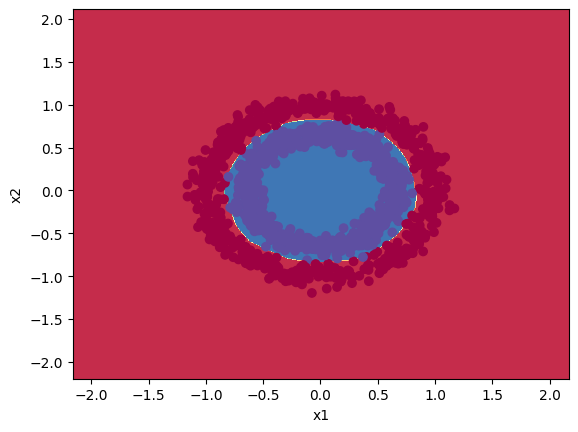

In [62]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)